In [1]:
import lightgbm

In [2]:
import xgboost as xgb

In [3]:
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import lightgbm
import xgboost as xgb

In [4]:
train = pd.read_csv("data/aug_train.csv")

In [5]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [7]:
train.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [8]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [9]:
#profile = ProfileReport(train)

In [10]:
train = train.loc[:, train.columns[~ train.columns.str.contains("_id")]]

In [11]:
train.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## NaN

In [12]:
train.isnull().mean()

city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [13]:
train.dropna(axis=0, inplace=True)

In [14]:
train.reset_index(inplace=True)

In [15]:
train.drop("index", axis=1, inplace=True)

In [16]:
train.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

In [17]:
for c in train.columns:
    print(c, train[str(c)].nunique())

city 116
city_development_index 91
gender 3
relevent_experience 2
enrolled_university 3
education_level 3
major_discipline 6
experience 22
company_size 8
company_type 6
last_new_job 6
training_hours 241
target 2


## feature eng

### city: high cardinality

In [18]:
mapping = train.city.value_counts()

In [19]:
train.city = train.city.map(mapping)

### gender

In [20]:
train = pd.get_dummies(train, columns=["gender"], drop_first=True)

### relevent_experience

In [21]:
train.relevent_experience.unique()

array(['No relevent experience', 'Has relevent experience'], dtype=object)

In [22]:
rev_exp_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"relevent_experience",
        "mapping":{
            "No relevent experience" : 0,
            "Has relevent experience" : 1
        }
    }
]
)

In [23]:
train = rev_exp_ord_encoder.fit_transform(train)

### enrolled_university

In [24]:
train.enrolled_university.unique()

array(['no_enrollment', 'Part time course', 'Full time course'],
      dtype=object)

In [25]:
univ_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"enrolled_university",
        "mapping":{
            "no_enrollment" : 0,
            "Part time course" : 1,
            "Full time course" : 2
        }
    }
]
)

In [26]:
train = univ_ord_encoder.fit_transform(train)

### education_level

In [28]:
train.education_level.unique()

array(['Graduate', 'Masters', 'Phd'], dtype=object)

In [29]:
ed_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"education_level",
        "mapping":{
            "Graduate" : 1,
            "Masters" : 2,
            "Phd" : 3
        }
    }
]
)

In [30]:
train = ed_ord_encoder.fit_transform(train)

### major_discipline

In [31]:
train.major_discipline.unique()

array(['STEM', 'Humanities', 'Business Degree', 'Other', 'No Major',
       'Arts'], dtype=object)

In [32]:
train = pd.get_dummies(train, columns=["major_discipline"], drop_first=True)

### experience

In [33]:
train.experience.unique()

array(['15', '>20', '13', '7', '5', '16', '11', '<1', '18', '19', '12',
       '10', '9', '2', '6', '4', '14', '3', '8', '17', '20', '1'],
      dtype=object)

In [34]:
ex_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"experience",
        "mapping":{
            "<1" : 0,
            "1" : 1,
            "2" : 2,
            "4" : 4,
            "5" : 5,
            "6" : 6,
            "7" : 7,
            "8" : 8,
            "9" : 9,
            "10" : 10,
            "11" : 11,
            "12" : 12,
            "13" : 13,
            "14" : 14,
            "15" : 15,
            "16" : 16,
            "17" : 17,
            "18" : 18,
            "19" : 19,
            "20" : 20,
            ">20": 21
        }
    }
]
)

In [35]:
train = ex_ord_encoder.fit_transform(train)

### company_size

In [36]:
train.company_size.unique()

array(['50-99', '<10', '5000-9999', '1000-4999', '10/49', '100-500',
       '10000+', '500-999'], dtype=object)

In [37]:
comp_size_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"company_size",
        "mapping":{
            "<10" : 0,
            "10/49" : 1,
            "50-99" : 2,
            "100-500" : 3,
            "500-999" : 4,
            "1000-4999" : 5,
            "5000-9999" : 6,
            "10000+" : 7,
        }
    }
]
)

In [38]:
train = comp_size_ord_encoder.fit_transform(train)

### company_type

In [39]:
train.company_type.unique()

array(['Pvt Ltd', 'Funded Startup', 'Early Stage Startup',
       'Public Sector', 'NGO', 'Other'], dtype=object)

In [40]:
train = pd.get_dummies(train, columns = ["company_type"], drop_first=True)

### last_new_job

In [41]:
train.last_new_job.unique()

array(['>4', '4', '1', '3', '2', 'never'], dtype=object)

In [42]:
last_n_j_ord_encoder = ce.OrdinalEncoder(
mapping=[
    {
        "col":"last_new_job",
        "mapping":{
            "never" : 0,
            "1" : 1,
            "2" : 2,
            "3" : 3,
            "4" : 4,
            ">4" : 5
        }
    }
]
)

In [43]:
train = last_n_j_ord_encoder.fit_transform(train)

In [45]:
train["experience"] = train["experience"].astype("int32")

### target

In [47]:
train.target = train.target.astype("uint8")

<IPython.core.display.Javascript object>


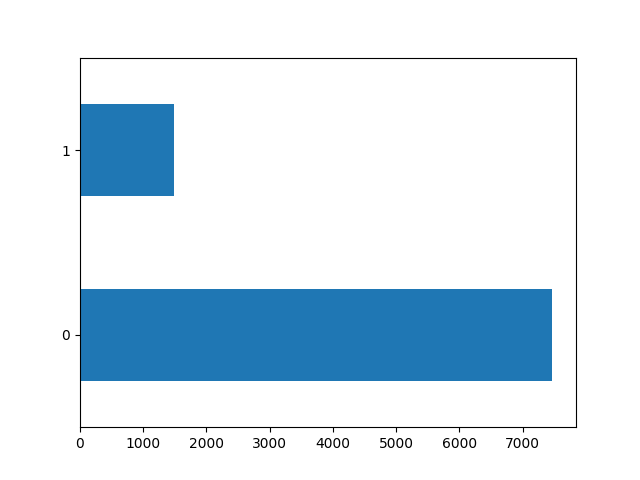

In [48]:
plt.figure()
train.target.value_counts().plot.barh()
plt.show()

# standardizing

In [49]:
sca = StandardScaler()

### city_development_index and training_hours

In [50]:
train.loc[:, ["city_development_index", "training_hours"]] = sca.fit_transform(train.loc[:, ["city_development_index", "training_hours"]])

# DUMMY 1ST MODEL

In [51]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score


In [52]:
X = train.drop("target", axis=1)
y = train.target

In [53]:
folds = 10

In [54]:
skf = StratifiedKFold(n_splits=folds)
skf.get_n_splits(X, y)

10

In [55]:
def run_kfold(X, y, model, folds=10):
    skf = StratifiedKFold(n_splits=folds)
    skf.get_n_splits(X, y)
    roc_auc_avg = 0
    k = 0
    for train_index, test_index in skf.split(X, y):
        k+=1
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        
        roc_auc_avg += roc_auc_score(y_pred, y_test)

      
        print("\nfold " + str(k) + " " + str(roc_auc_score(y_pred, y_test)))
        print('Accuracy: %f, \nRecall: %f \nPrecision: %f'
          % (accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)))



    print("avg roc_auc score is " + str(roc_auc_avg/k))
    

In [56]:
lg = linear_model.LogisticRegression(max_iter=3000)
run_kfold(X, y, lg, folds=10)


fold 1 0.7861582861582861
Accuracy: 0.867188, 
Recall: 0.358108 
Precision: 0.688312

fold 2 0.7497653973428162
Accuracy: 0.859375, 
Recall: 0.418919 
Precision: 0.607843

fold 3 0.7377136752136753
Accuracy: 0.853795, 
Recall: 0.409396 
Precision: 0.586538

fold 4 0.7410548602030015
Accuracy: 0.854911, 
Recall: 0.402685 
Precision: 0.594059

fold 5 0.7144014929352173
Accuracy: 0.843750, 
Recall: 0.436242 
Precision: 0.537190

fold 6 0.71667631731326
Accuracy: 0.845810, 
Recall: 0.405405 
Precision: 0.545455

fold 7 0.7367968891300416
Accuracy: 0.853631, 
Recall: 0.385135 
Precision: 0.587629

fold 8 0.7294774008102665
Accuracy: 0.851397, 
Recall: 0.432432 
Precision: 0.566372

fold 9 0.7008094498564639
Accuracy: 0.839106, 
Recall: 0.378378 
Precision: 0.518519

fold 10 0.7529530978575565
Accuracy: 0.861453, 
Recall: 0.452703 
Precision: 0.609091
avg roc_auc score is 0.7365806866820586


In [57]:
rfc = RandomForestClassifier(random_state=0)
run_kfold(X, y, rfc, folds=10)


fold 1 0.763421285034783
Accuracy: 0.860491, 
Recall: 0.344595 
Precision: 0.645570

fold 2 0.7331528920335877
Accuracy: 0.851562, 
Recall: 0.344595 
Precision: 0.586207

fold 3 0.7417304230423043
Accuracy: 0.853795, 
Recall: 0.355705 
Precision: 0.602273

fold 4 0.7270089395959894
Accuracy: 0.849330, 
Recall: 0.389262 
Precision: 0.568627

fold 5 0.7102083333333333
Accuracy: 0.842634, 
Recall: 0.348993 
Precision: 0.541667

fold 6 0.7285573883709193
Accuracy: 0.850279, 
Recall: 0.364865 
Precision: 0.574468

fold 7 0.7523308630169735
Accuracy: 0.859218, 
Recall: 0.391892 
Precision: 0.617021

fold 8 0.7165506851280581
Accuracy: 0.845810, 
Recall: 0.391892 
Precision: 0.547170

fold 9 0.7138665068168512
Accuracy: 0.844693, 
Recall: 0.331081 
Precision: 0.550562

fold 10 0.7360338678704142
Accuracy: 0.853631, 
Recall: 0.398649 
Precision: 0.584158
avg roc_auc score is 0.7322861184243215


# running with PCA

In [58]:
pca = PCA(random_state=0)
X_pca = pca.fit_transform(X)

In [59]:
X_pca

array([[-9.45667421e+02, -4.21592226e+00, -8.67832757e-01, ...,
        -1.45086875e-02,  8.51480092e-04,  3.30263589e-03],
       [-9.36664774e+02, -1.00752899e+01, -1.24277550e+00, ...,
         3.99037831e-04,  1.25058509e-02,  4.77482033e-03],
       [-9.18669173e+02, -2.15909714e+00, -2.79239118e+00, ...,
        -6.22236455e-05,  2.04937713e-02, -1.22518821e-03],
       ...,
       [-5.73669363e+02,  1.05737884e+00, -2.32554648e-02, ...,
        -9.28930878e-02,  2.99954379e-02, -1.05865044e-02],
       [ 1.45132778e+03,  5.33479414e+00, -2.86875113e+00, ...,
        -8.26058596e-02,  1.00617634e-02, -3.45032684e-02],
       [ 1.45133507e+03, -8.91504402e+00, -2.08778918e+00, ...,
        -2.40842576e-03,  3.77719190e-03, -6.00035944e-03]])

In [60]:
pca.explained_variance_ratio_

array([9.99936569e-01, 5.22375600e-05, 5.19321022e-06, 2.49862751e-06,
       1.10305054e-06, 9.14800479e-07, 3.88123781e-07, 3.06031406e-07,
       2.28561205e-07, 1.35506299e-07, 1.06060180e-07, 9.47612251e-08,
       7.19610581e-08, 5.10158861e-08, 3.33831597e-08, 2.13215846e-08,
       1.53581193e-08, 1.39025811e-08, 8.62515083e-09, 5.93171189e-09,
       2.79532342e-09])

In [61]:
pca.components_[0]

array([ 9.99999761e-01,  2.85224632e-04,  8.22518502e-07, -5.19433475e-05,
       -5.96037372e-05,  4.72747592e-04,  3.83330791e-04,  1.30525916e-04,
        1.32619421e-06, -2.00715753e-05,  8.09215448e-07,  6.54528381e-06,
        1.98267721e-05, -4.59572684e-07,  3.48670428e-06, -3.93903567e-05,
        9.46913472e-06,  1.13441962e-05,  3.81520049e-06, -1.61083742e-06,
       -1.53131247e-05])

In [62]:
print(np.shape(X))
print(np.shape(pca.components_[0]))

(8955, 21)
(21,)


<IPython.core.display.Javascript object>


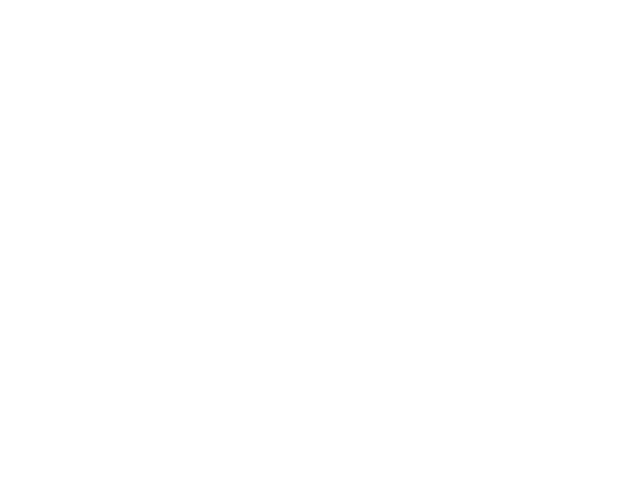

<IPython.core.display.Javascript object>


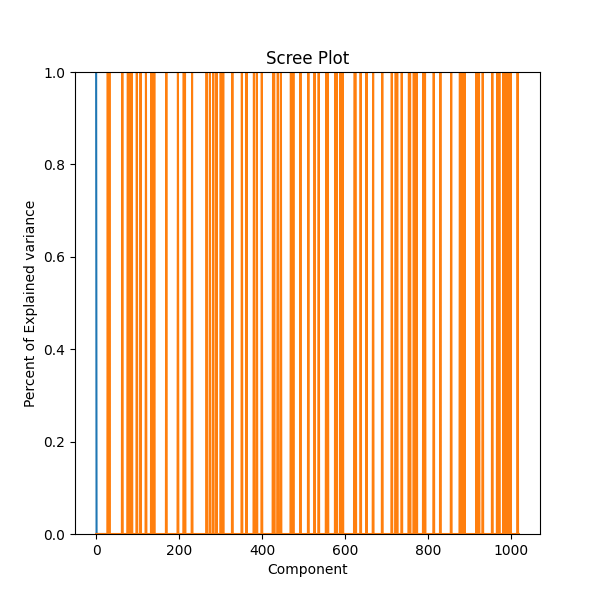

In [63]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pca.explained_variance_ratio_)

ax.set(xlabel="Component", ylabel="Percent of Explained variance", title="Scree Plot", ylim=(0,1))

plt.savefig("pca.png")
plt.show()

# RFE

In [64]:
train.dtypes

city                                  int64
city_development_index              float64
relevent_experience                   int64
enrolled_university                   int64
education_level                       int64
experience                            int32
company_size                          int64
last_new_job                          int64
training_hours                      float64
target                                uint8
gender_Male                           uint8
gender_Other                          uint8
major_discipline_Business Degree      uint8
major_discipline_Humanities           uint8
major_discipline_No Major             uint8
major_discipline_Other                uint8
major_discipline_STEM                 uint8
company_type_Funded Startup           uint8
company_type_NGO                      uint8
company_type_Other                    uint8
company_type_Public Sector            uint8
company_type_Pvt Ltd                  uint8
dtype: object

In [65]:
rfe = RFE(rfc)

In [66]:
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(random_state=0))

In [67]:
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  2, 11,  9,  7, 12, 10,  3,  4,
        6,  8,  5,  1])

In [68]:
rfe.estimator_.n_features_

10

In [69]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [70]:
rfe_cols = X.columns[rfe.support_]

In [71]:
rfe_cols

Index(['city', 'city_development_index', 'relevent_experience',
       'enrolled_university', 'education_level', 'experience', 'company_size',
       'last_new_job', 'training_hours', 'company_type_Pvt Ltd'],
      dtype='object')

In [72]:
X_rfe = X.loc[:, rfe_cols]

In [73]:
lg = linear_model.LogisticRegression(max_iter=3000)
run_kfold(X_rfe, y, lg, folds=10)


fold 1 0.7809257003654081
Accuracy: 0.864955, 
Recall: 0.344595 
Precision: 0.680000

fold 2 0.7447236180904523
Accuracy: 0.857143, 
Recall: 0.405405 
Precision: 0.600000

fold 3 0.7564264643910662
Accuracy: 0.861607, 
Recall: 0.436242 
Precision: 0.619048

fold 4 0.7461158927019185
Accuracy: 0.857143, 
Recall: 0.416107 
Precision: 0.601942

fold 5 0.716709621993127
Accuracy: 0.844866, 
Recall: 0.436242 
Precision: 0.541667

fold 6 0.7322235089751014
Accuracy: 0.852514, 
Recall: 0.425676 
Precision: 0.572727

fold 7 0.7372368421052632
Accuracy: 0.853631, 
Recall: 0.378378 
Precision: 0.589474

fold 8 0.7318511796733213
Accuracy: 0.852514, 
Recall: 0.445946 
Precision: 0.568966

fold 9 0.7136720667648502
Accuracy: 0.844693, 
Recall: 0.358108 
Precision: 0.546392

fold 10 0.732602769208695
Accuracy: 0.852514, 
Recall: 0.412162 
Precision: 0.575472
avg roc_auc score is 0.7392487664269203


In [74]:
rfc = RandomForestClassifier(random_state=0)
run_kfold(X_rfe, y, rfc, folds=10)


fold 1 0.759313725490196
Accuracy: 0.859375, 
Recall: 0.344595 
Precision: 0.637500

fold 2 0.732202580028667
Accuracy: 0.851562, 
Recall: 0.358108 
Precision: 0.582418

fold 3 0.7376970855231725
Accuracy: 0.852679, 
Recall: 0.362416 
Precision: 0.593407

fold 4 0.7491356744209019
Accuracy: 0.858259, 
Recall: 0.416107 
Precision: 0.607843

fold 5 0.7077216910099291
Accuracy: 0.841518, 
Recall: 0.369128 
Precision: 0.533981

fold 6 0.7195723684210525
Accuracy: 0.846927, 
Recall: 0.358108 
Precision: 0.557895

fold 7 0.7471943038132529
Accuracy: 0.858101, 
Recall: 0.412162 
Precision: 0.603960

fold 8 0.7141478212906784
Accuracy: 0.844693, 
Recall: 0.405405 
Precision: 0.540541

fold 9 0.713712995984737
Accuracy: 0.844693, 
Recall: 0.371622 
Precision: 0.544554

fold 10 0.7288903026693379
Accuracy: 0.850279, 
Recall: 0.358108 
Precision: 0.576087
avg roc_auc score is 0.7309588548651925


# xgboost

In [75]:
X_rfe.dtypes

city                        int64
city_development_index    float64
relevent_experience         int64
enrolled_university         int64
education_level             int64
experience                  int32
company_size                int64
last_new_job                int64
training_hours            float64
company_type_Pvt Ltd        uint8
dtype: object

In [76]:
xgbc = xgb.XGBClassifier()
run_kfold(X_rfe, y, xgbc, folds=10)

[14:17:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 1 0.7715287349433692
Accuracy: 0.863839, 
Recall: 0.364865 
Precision: 0.658537
[14:17:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 2 0.7410772225827384
Accuracy: 0.854911, 
Recall: 0.371622 
Precision: 0.597826
[14:17:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 3 0.7191713868691332
Accuracy: 0.845982, 
Recall: 0.348993 
Precision: 0.559140
[14:17:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 4 0.740244416350611
Accuracy: 0.854911, 
Recall: 0.416107 
Precision: 0.590476
[14:17:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 5 0.7159899689515168
Accuracy: 0.844866, 
Recall: 0.389262 
Precision: 0.547170
[14:17:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 6 0.7310156835387437
Accuracy: 0.851397, 
Recall: 0.378378 
Precision: 0.577320
[14:17:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 7 0.7165923550271174
Accuracy: 0.845810, 
Recall: 0.358108 
Precision: 0.552083
[14:17:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 8 0.7080034008425968
Accuracy: 0.842458, 
Recall: 0.358108 
Precision: 0.535354
[14:17:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 9 0.7292615596963422
Accuracy: 0.850279, 
Recall: 0.351351 
Precision: 0.577778
[14:17:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 10 0.73541289933695
Accuracy: 0.853631, 
Recall: 0.412162 
Precision: 0.580952
avg roc_auc score is 0.7308297628139118


# light gbm

In [77]:
lgbm = lightgbm.LGBMClassifier(random_state=0)

In [78]:
run_kfold(X_rfe, y, lgbm, folds=10)


fold 1 0.749497559575079
Accuracy: 0.857143, 
Recall: 0.358108 
Precision: 0.616279

fold 2 0.7467464097258781
Accuracy: 0.858259, 
Recall: 0.418919 
Precision: 0.601942

fold 3 0.7425717852684145
Accuracy: 0.854911, 
Recall: 0.382550 
Precision: 0.600000

fold 4 0.740244416350611
Accuracy: 0.854911, 
Recall: 0.416107 
Precision: 0.590476

fold 5 0.7239003709591946
Accuracy: 0.848214, 
Recall: 0.442953 
Precision: 0.554622

fold 6 0.7219013798216036
Accuracy: 0.848045, 
Recall: 0.398649 
Precision: 0.556604

fold 7 0.7505894437052081
Accuracy: 0.860335, 
Recall: 0.445946 
Precision: 0.605505

fold 8 0.71667631731326
Accuracy: 0.845810, 
Recall: 0.405405 
Precision: 0.545455

fold 9 0.7245362683239244
Accuracy: 0.849162, 
Recall: 0.405405 
Precision: 0.560748

fold 10 0.7741063548102384
Accuracy: 0.869274, 
Recall: 0.452703 
Precision: 0.650485
avg roc_auc score is 0.7390770305853411


# upsampling

In [79]:
from sklearn.utils import resample

In [85]:
len(train[train.target==0])

1483

In [84]:
# Separate majority and minority classes
train_majority = train[train.target==0]
train_minority = train[train.target==1]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=7472,    # to match majority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
 
# Display new class counts
train_upsampled.target.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    7472
0    7472
Name: target, dtype: int64

In [109]:
train_upsampled.reset_index(inplace=True)
train_upsampled.drop("index", axis=1, inplace=True)

In [110]:
X_up_rfe = train_upsampled[X_rfe.columns]
y_up_rfe = train_upsampled.target

## logistic reg

In [113]:
lg = linear_model.LogisticRegression(random_state=0, max_iter=3000)
run_kfold(X_up_rfe, y_up_rfe, lg, folds=10)


fold 1 0.745270018621974
Accuracy: 0.735786, 
Recall: 0.637216 
Precision: 0.793333

fold 2 0.7562467003614373
Accuracy: 0.748495, 
Recall: 0.661312 
Precision: 0.800648

fold 3 0.7416350497849306
Accuracy: 0.731773, 
Recall: 0.631016 
Precision: 0.790620

fold 4 0.7444514145682926
Accuracy: 0.738462, 
Recall: 0.660428 
Precision: 0.782884

fold 5 0.7245484058936152
Accuracy: 0.717537, 
Recall: 0.629183 
Precision: 0.764228

fold 6 0.704514343077906
Accuracy: 0.692771, 
Recall: 0.572959 
Precision: 0.753521

fold 7 0.7473313744044358
Accuracy: 0.740295, 
Recall: 0.655957 
Precision: 0.789050

fold 8 0.7248795825528499
Accuracy: 0.716867, 
Recall: 0.622490 
Precision: 0.767327

fold 9 0.7459322334244224
Accuracy: 0.736278, 
Recall: 0.637216 
Precision: 0.794658

fold 10 0.7271590755507501
Accuracy: 0.716867, 
Recall: 0.610442 
Precision: 0.775510
avg roc_auc score is 0.7361968198240614


## random forest

In [114]:
rfc = RandomForestClassifier(random_state=0)
run_kfold(X_up_rfe, y_up_rfe, rfc, folds=10)


fold 1 0.9678776572418603
Accuracy: 0.965886, 
Recall: 0.998661 
Precision: 0.937186

fold 2 0.9547367041144695
Accuracy: 0.953177, 
Recall: 0.982597 
Precision: 0.927939

fold 3 0.961197614262654
Accuracy: 0.959197, 
Recall: 0.991979 
Precision: 0.930991

fold 4 0.9616318178061568
Accuracy: 0.959866, 
Recall: 0.990642 
Precision: 0.933249

fold 5 0.9564967783749433
Accuracy: 0.953146, 
Recall: 0.995984 
Precision: 0.917386

fold 6 0.9580428773376793
Accuracy: 0.955823, 
Recall: 0.990629 
Precision: 0.926158

fold 7 0.963205710577547
Accuracy: 0.960509, 
Recall: 0.998661 
Precision: 0.927861

fold 8 0.9516682195745694
Accuracy: 0.949130, 
Recall: 0.986613 
Precision: 0.917808

fold 9 0.9532308625745778
Accuracy: 0.949799, 
Recall: 0.993307 
Precision: 0.913793

fold 10 0.9545797639512879
Accuracy: 0.951138, 
Recall: 0.994645 
Precision: 0.915025
avg roc_auc score is 0.9582668005815748


## xgboost

In [115]:
xgbc = xgb.XGBClassifier()
run_kfold(X_up_rfe, y_up_rfe, xgbc, folds=10)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

fold 1 0.8998444091127201
Accuracy: 0.899666, 
Recall: 0.910308 
Precision: 0.891219
[14:36:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 2 0.9015591397849463
Accuracy: 0.901003, 
Recall: 0.919679 
Precision: 0.886452
[14:36:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 3 0.8944563205179162
Accuracy: 0.894314, 
Recall: 0.903743 
Precision: 0.887139
[14:36:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 4 0.8961381873438772
Accuracy: 0.895652, 
Recall: 0.913102 
Precision: 0.882429
[14:36:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 5 0.8867549015209296
Accuracy: 0.886212, 
Recall: 0.904953 
Precision: 0.872258
[14:36:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 6 0.8902275769745649
Accuracy: 0.890228, 
Recall: 0.890228 
Precision: 0.890228
[14:36:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 7 0.8961062538646266
Accuracy: 0.894913, 
Recall: 0.922356 
Precision: 0.874365
[14:36:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 8 0.8734946452380611
Accuracy: 0.873494, 
Recall: 0.874163 
Precision: 0.872995
[14:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 9 0.8854945800552495
Accuracy: 0.884873, 
Recall: 0.904953 
Precision: 0.870013
[14:36:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



fold 10 0.8795289546643058
Accuracy: 0.879518, 
Recall: 0.882195 
Precision: 0.877497
avg roc_auc score is 0.8903604969077197


## light gbm

In [116]:
lgbm = lightgbm.LGBMClassifier(random_state=0)
run_kfold(X_up_rfe, y_up_rfe, lgbm, folds=10)


fold 1 0.8446040047438915
Accuracy: 0.840134, 
Recall: 0.783133 
Precision: 0.883686

fold 2 0.840294303866559
Accuracy: 0.834783, 
Recall: 0.771084 
Precision: 0.883436

fold 3 0.82705220748699
Accuracy: 0.820736, 
Recall: 0.751337 
Precision: 0.872671

fold 4 0.846262095146669
Accuracy: 0.840803, 
Recall: 0.778075 
Precision: 0.889908

fold 5 0.8218134820959169
Accuracy: 0.815930, 
Recall: 0.748327 
Precision: 0.865325

fold 6 0.8157496045950221
Accuracy: 0.805890, 
Recall: 0.717537 
Precision: 0.871545

fold 7 0.8425591113903957
Accuracy: 0.838019, 
Recall: 0.780455 
Precision: 0.881997

fold 8 0.8101089580645574
Accuracy: 0.804552, 
Recall: 0.737617 
Precision: 0.851623

fold 9 0.8327013132444263
Accuracy: 0.827979, 
Recall: 0.768407 
Precision: 0.872340

fold 10 0.8214079297191077
Accuracy: 0.813922, 
Recall: 0.737617 
Precision: 0.870458
avg roc_auc score is 0.8302553010353535


## refactoring and testing

In [165]:
def treat_data(df):
    
    #df = df.loc[:, df.columns[~ df.columns.str.contains("_id")]]
    df.dropna(axis=0, inplace=True)

    df.reset_index(inplace=True)
    df.drop("index", axis=1, inplace=True)

    mapping = df.city.value_counts()
    df.city = df.city.map(mapping)
    df = pd.get_dummies(df, columns=["gender"], drop_first=True)

    rev_exp_ord_encoder = ce.OrdinalEncoder(
    mapping=[
        {
            "col":"relevent_experience",
            "mapping":{
                "No relevent experience" : 0,
                "Has relevent experience" : 1
            }
        }
    ]
    )
    df = rev_exp_ord_encoder.fit_transform(df)



    univ_ord_encoder = ce.OrdinalEncoder(
    mapping=[
        {
            "col":"enrolled_university",
            "mapping":{
                "no_enrollment" : 0,
                "Part time course" : 1,
                "Full time course" : 2
            }
        }
    ]
    )

    df = univ_ord_encoder.fit_transform(df)

    ed_ord_encoder = ce.OrdinalEncoder(
    mapping=[
        {
            "col":"education_level",
            "mapping":{
                "Graduate" : 1,
                "Masters" : 2,
                "Phd" : 3
            }
        }
    ]
    )
    df = ed_ord_encoder.fit_transform(df)


    df = pd.get_dummies(df, columns=["major_discipline"], drop_first=True)


    ex_ord_encoder = ce.OrdinalEncoder(
    mapping=[
        {
            "col":"experience",
            "mapping":{
                "<1" : 0,
                "1" : 1,
                "2" : 2,
                "4" : 4,
                "5" : 5,
                "6" : 6,
                "7" : 7,
                "8" : 8,
                "9" : 9,
                "10" : 10,
                "11" : 11,
                "12" : 12,
                "13" : 13,
                "14" : 14,
                "15" : 15,
                "16" : 16,
                "17" : 17,
                "18" : 18,
                "19" : 19,
                "20" : 20,
                ">20": 21
            }
        }
    ]
    )
    df = ex_ord_encoder.fit_transform(df)


    comp_size_ord_encoder = ce.OrdinalEncoder(
    mapping=[
        {
            "col":"company_size",
            "mapping":{
                "<10" : 0,
                "10/49" : 1,
                "50-99" : 2,
                "100-500" : 3,
                "500-999" : 4,
                "1000-4999" : 5,
                "5000-9999" : 6,
                "10000+" : 7,
            }
        }
    ]
    )

    df = comp_size_ord_encoder.fit_transform(df)

    df = pd.get_dummies(df, columns = ["company_type"], drop_first=True)


    last_n_j_ord_encoder = ce.OrdinalEncoder(
    mapping=[
        {
            "col":"last_new_job",
            "mapping":{
                "never" : 0,
                "1" : 1,
                "2" : 2,
                "3" : 3,
                "4" : 4,
                ">4" : 5
            }
        }
    ]
    )

    df = last_n_j_ord_encoder.fit_transform(df)

    df["experience"] = df["experience"].astype("int32")

    #df["target"] = df["target"].astype("uint8")

    sca = StandardScaler()

    df.loc[:, ["city_development_index", "training_hours"]] = sca.fit_transform(df.loc[:, ["city_development_index", "training_hours"]])
    
    return df

## test data

In [167]:
test = pd.read_csv("data/aug_test.csv")

In [168]:
test = treat_data(test)

In [188]:
test_prob = rfc.predict_proba(test[X_rfe.columns])

In [189]:
test_prob = [ i[1] for i in test_prob]

In [169]:
test_pred = rfc.predict(test[X_rfe.columns])

<IPython.core.display.Javascript object>


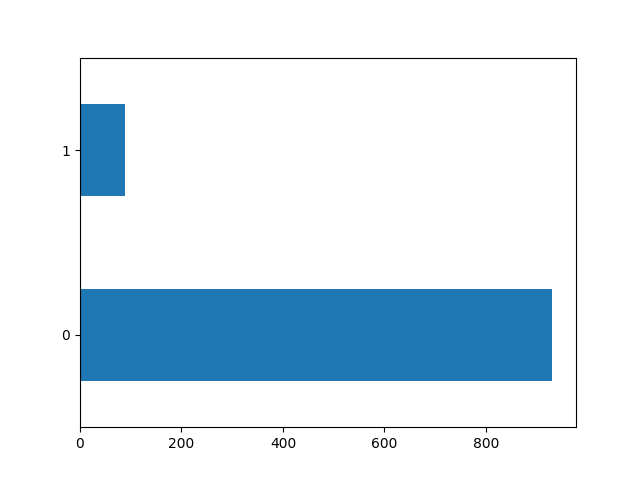

In [170]:
plt.figure()
pd.Series(test_pred).value_counts().plot.barh()
plt.savefig("test.png")
plt.show()

In [191]:
pd.read_csv("data/sample_submission.csv")

,enrollee_id,target
0,32403,0.5
1,9858,0.5
2,31806,0.5
3,27385,0.5
4,27724,0.5
...,...,...
2124,1289,0.5
2125,195,0.5
2126,31762,0.5
2127,7873,0.5


In [194]:
result = pd.DataFrame({
    "enrollee_id" : test["enrollee_id"],
    "targer" : test_prob
})

In [195]:
result.to_csv("submission.csv", index=False)